## Create data

In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg
import matplotlib.pyplot as plt

In [2]:
def getData(size=5100, numChanges = 10):
    #maxchanges = 50
    #numChanges = random.randint(10, maxchanges)
    #numChanges = 10
    t = np.arange(0,size*0.8,0.8)
    rlist = list()
    while numChanges:
        r = random.randint(1,size)
        if r not in rlist:
            rlist.append(r)
        numChanges -= 1
    rlist.sort()

    for i in range(len(t)):
        if i in rlist:
            for j in range(i, len(t)):
                t[j] = -t[j]

    p=5
    data = 1/2 * p * t % (2 * p)
    
    y1 = list()
    y2 = list()
    for i in range(len(t)):
        if t[i] < 0:
            y1.append(1)
            y2.append(0)
        else:
            y1.append(0)
            y2.append(1)
            
    return data, y1, y2

In [3]:
data, y1, y2 = getData()

# ESN

In [4]:
def trainESN(data, y1, y2, initLen, trainLen, testLen, inSize, outSize, resSize, a, reg, spec, scale):
    random.seed(42)
    Win = random.rand(resSize,1+inSize) - scale
    W = random.rand(resSize,resSize) - scale

    # normalizing and setting spectral radius (correct, slow):
    rhoW = max(abs(linalg.eig(W)[0]))
    #print("Spectral Radius: ", rhoW)
    W *= spec / rhoW

    # allocated memory for the design (collected states) matrix
    X = zeros((1+inSize+resSize,trainLen-initLen))
    # set the corresponding target matrix directly
    Yt = [y1[initLen+1:trainLen+1], y2[initLen+1:trainLen+1]]

    # run the reservoir with the data and collect X
    x = zeros((resSize,1))
    for t in range(trainLen):
        u = data[t]
        x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
        if t >= initLen:
            X[:,t-initLen] = vstack((1,u,x))[:,0]

    # train the output by ridge regression
    X_T = X.T
    Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + \
        reg*eye(1+inSize+resSize) ) )

    # average absolute size of learned output weights
    avgout = sum(abs(Wout))/(len(Wout[0]) * outSize)
    #print("Average size output weights: ", avgout)


    # run the trained ESN with training data
    Y = zeros((outSize,trainLen))
    u = data[initLen] # starting point
    for t in range(trainLen):
        x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) ) # update internal activations
        y = dot( Wout, vstack((1,u,x)) ) # calculate outputs
        # save the outputs
        Y[:,t][0] = y[0]
        Y[:,t][1] = y[1]
        # get new input
        u = data[initLen+t+1] 



    # compute RMSE for the first errorLen time steps
    rmse1 = (sum( square( y1[initLen+1:initLen+trainLen+1] - 
        Y[0,0:trainLen] ) ) / trainLen)**(1/2.0)
    #print('RMSE = \t' + str( rmse1 ))
    nrmse1 = rmse1 / (max(y1) - min(y1))
    #print('train NRMSE = ', str(nrmse1) )

    # compute RMSE for the first errorLen time steps
    rmse2 = (sum( square( y2[initLen+1:initLen+trainLen+1] - 
        Y[1,0:trainLen] ) ) / trainLen) **(1/2.0)
    #print('RMSE = \t' + str( rmse2 ))
    nrmse2 = rmse2 / (max(y2) - min(y2))
    #print('NRMSE = ' + str( nrmse2 ))
    
    
    #-------------------------------------------------------------------TEST-------------------------------------
    # run the trained ESN with test data
    Y = zeros((outSize,testLen))
    u = data[trainLen] # starting point
    for t in range(testLen):
        x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) ) # update internal activations
        y = dot( Wout, vstack((1,u,x)) ) # calculate outputs
        # save the outputs
        Y[:,t][0] = y[0]
        Y[:,t][1] = y[1]
        # get new input
        u = data[trainLen+t+1] 
    
    # compute RMSE for the first errorLen time steps
    errorLen = testLen
    rmse3 = (sum( square( y1[trainLen+1:trainLen+errorLen+1] - 
        Y[0,0:errorLen] ) ) / errorLen)**(1/2.0)
    #print('RMSE = \t' + str( rmse3 ))
    nrmse3 = rmse3 / (max(y1) - min(y1))
    #print('test NRMSE  =  ' + str( nrmse3 ))
    
    # compute RMSE for the first errorLen time steps
    rmse4 = (sum( square( y2[trainLen+1:trainLen+errorLen+1] - 
        Y[1,0:errorLen] ) ) / errorLen) **(1/2.0)
    #print('RMSE = \t' + str( rmse4 ))
    nrmse4 = rmse4 / (max(y2) - min(y2))
    #print('NRMSE = ' + str( nrmse4 ))
    
    return avgout, nrmse1, nrmse2, nrmse3, nrmse4

In [5]:
initLen = 100
trainLen = 2500
testLen = 2500

In [6]:
# generate ESN reservoir
inSize = 1
outSize = 2
resSize = 50
a = 0.9 # leaking rate
reg = 1e-4  # regularization coefficient
spec = 1.4
scale = 0.5

In [7]:
traineval = list()
testeval = list()
for times in range(10):
    data, y1, y2 = getData(numChanges = 5)
    avg, n1, n2, n3, n4 = trainESN(data, y1, y2, initLen, trainLen, testLen, inSize, outSize, resSize, a, reg, spec, scale)
    traineval.append(n1)
    testeval.append(n3)
print("Train: \t mean: \t", mean(traineval), "\t std: \t", std(traineval))
print("Test:  \t mean: \t", mean(testeval), "\t std: \t", std(testeval))

Train: 	 mean: 	 0.05152847029652667 	 std: 	 0.003601219852924342
Test:  	 mean: 	 0.03197361798171307 	 std: 	 0.01081963621958958


In [19]:
# generate ESN reservoir
inSize = 1
outSize = 2
resSize = 300
a = 0.9 # leaking rate
reg = 1e-1  # regularization coefficient
spec = 1
scale = 0.5

In [20]:
traineval = list()
testeval = list()
for times in range(10):
    data, y1, y2 = getData(numChanges = 5)
    avg, n1, n2, n3, n4 = trainESN(data, y1, y2, initLen, trainLen, testLen, inSize, outSize, resSize, a, reg, spec, scale)
    traineval.append(n1)
    testeval.append(n3)
print("Train: \t mean: \t", mean(traineval), "\t std: \t", std(traineval))
print("Test:  \t mean: \t", mean(testeval), "\t std: \t", std(testeval))

Train: 	 mean: 	 0.04481090331247683 	 std: 	 0.0
Test:  	 mean: 	 0.0025664933778220818 	 std: 	 0.0


## Input Scaling 

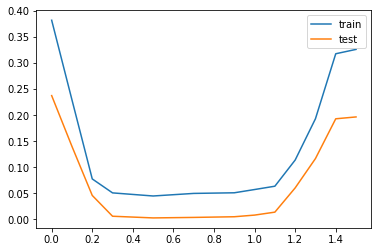

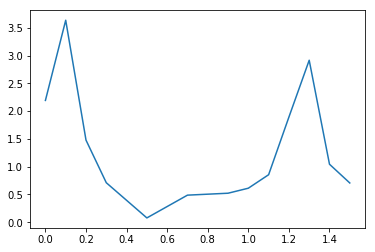

In [10]:
# generate ESN reservoir
inSize = 1
outSize = 2
resSize = 300
a = 0.9 # leaking rate
reg = 1e-2  # regularization coefficient
spec = 1
#scale = 0.7
trainmean = list()
testmean = list()
avgoutmean = list()
tries = [ 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
for r in tries:
    traineval = list()
    testeval = list()
    avgout = list()
    for times in range(10):
        data, y1, y2 = getData(numChanges = 5)
        avg, n1, n2, n3, n4 = trainESN(data, y1, y2, initLen, trainLen, testLen, inSize, outSize, resSize, a, reg, spec, r)
        traineval.append(n1)
        testeval.append(n3)
        avgout.append(avg)
    trainmean.append(mean(traineval))
    testmean.append(mean(testeval))
    avgoutmean.append(mean(avgout))
plt.plot(tries, trainmean)
plt.plot(tries, testmean)
plt.legend(['train', 'test'])
plt.show()

plt.plot(tries, avgoutmean)
plt.show()

## Spectral Radius

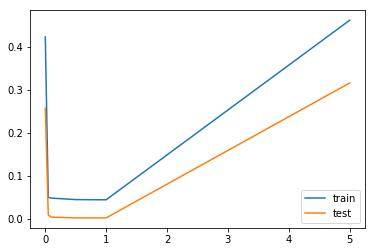

In [11]:
# generate ESN reservoir
inSize = 1
outSize = 2
resSize = 300
a = 0.9 # leaking rate
reg = 1e-2  # regularization coefficient
#spec = 1.4
scale = 0.5
trainmean = list()
testmean = list()
avgoutmean = list()
tries = [0.001, 0.05, 0.1, 0.5, 1, 5]
for r in tries:
    traineval = list()
    testeval = list()
    avgout = list()
    for times in range(10):
        data, y1, y2 = getData(numChanges = 5)
        avg, n1, n2, n3, n4 = trainESN(data, y1, y2, initLen, trainLen, testLen, inSize, outSize, resSize, a, reg, r, scale)
        traineval.append(n1)
        testeval.append(n3)
        avgout.append(avg)
    trainmean.append(mean(traineval))
    testmean.append(mean(testeval))
    avgoutmean.append(mean(avgout))
plt.plot(tries, trainmean)
plt.plot(tries, testmean)
plt.legend(['train', 'test'])
plt.show()

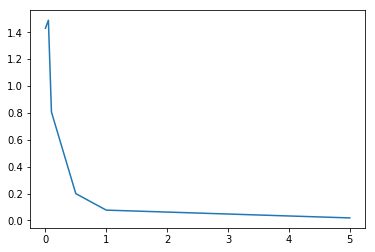

In [12]:
plt.plot(tries, avgoutmean)
plt.show()

## Leaking rate

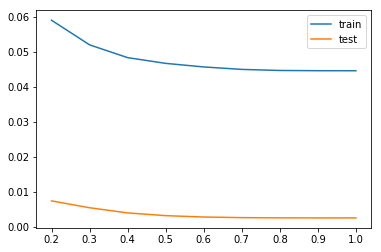

In [13]:
# generate ESN reservoir
inSize = 1
outSize = 2
resSize = 300
#a = 0.9 # leaking rate
reg = 1e-2  # regularization coefficient
spec = 1
scale = 0.5
trainmean = list()
testmean = list()
avgoutmean = list()
tries = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
for r in tries:
    traineval = list()
    testeval = list()
    avgout = list()
    for times in range(10):
        data, y1, y2 = getData(numChanges = 5)
        avg, n1, n2, n3, n4 = trainESN(data, y1, y2, initLen, trainLen, testLen, inSize, outSize, resSize, r, reg, spec, scale)
        traineval.append(n1)
        testeval.append(n3)
        avgout.append(avg)
    trainmean.append(mean(traineval))
    testmean.append(mean(testeval))
    avgoutmean.append(mean(avgout))
plt.plot(tries, trainmean)
plt.plot(tries, testmean)
plt.legend(['train', 'test'])
plt.show()

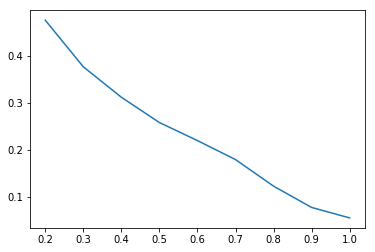

In [14]:
plt.plot(tries, avgoutmean)
plt.show()

## Reservoir Size

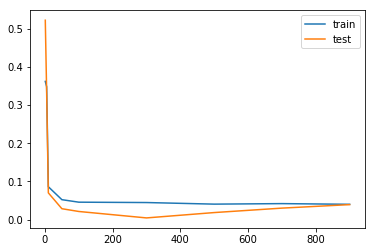

In [15]:
# generate ESN reservoir
inSize = 1
outSize = 2
#resSize = 50
a = 0.9 # leaking rate
reg = 1e-2  # regularization coefficient
spec = 1
scale = 0.5
trainmean = list()
testmean = list()
avgoutmean = list()
tries = [1, 5, 10, 50, 100, 300, 500, 700, 900]
for r in tries:
    traineval = list()
    testeval = list()
    avgout = list()
    for times in range(10):
        data, y1, y2 = getData(numChanges = 5)
        avg, n1, n2, n3, n4 = trainESN(data, y1, y2, initLen, trainLen, testLen, inSize, outSize, r, a, reg, spec, scale)
        traineval.append(n1)
        testeval.append(n3)
        avgout.append(avg)
    trainmean.append(mean(traineval))
    testmean.append(mean(testeval))
    avgoutmean.append(mean(avgout))
plt.plot(tries, trainmean)
plt.plot(tries, testmean)
plt.legend(['train', 'test'])
plt.show()

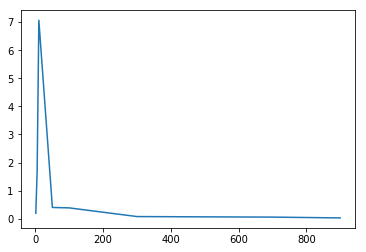

In [16]:
plt.plot(tries, avgoutmean)
plt.show()

# Ridge regression regularization parameter

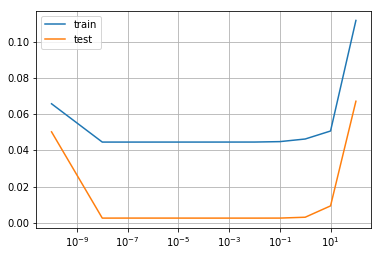

In [17]:
# generate ESN reservoir
inSize = 1
outSize = 2
resSize = 300
a = 0.9 # leaking rate
#reg = 1e-4  # regularization coefficient
spec = 1
scale = 0.5
trainmean = list()
testmean = list()
avgoutmean = list()
tries =  [100, 10, 1, 1e-1, 1e-2, 1e-4, 1e-6, 1e-7, 1e-8, 1e-10]
for r in tries:
    traineval = list()
    testeval = list()
    avgout = list()
    for times in range(10):
        data, y1, y2 = getData(numChanges = 5)
        avg, n1, n2, n3, n4 = trainESN(data, y1, y2, initLen, trainLen, testLen, inSize, outSize, resSize, a, r, spec, scale)
        traineval.append(n1)
        testeval.append(n3)
        avgout.append(avg)
    trainmean.append(mean(traineval))
    testmean.append(mean(testeval))
    avgoutmean.append(mean(avgout))
plt.semilogx(tries, trainmean)
plt.semilogx(tries, testmean)
plt.grid()
plt.legend(['train', 'test'])
plt.show()

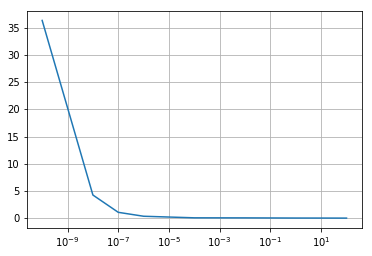

In [18]:
plt.semilogx(tries, avgoutmean)
plt.grid()
plt.show()